In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTG
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

In [3]:
# real estate data
data = {
    "train_data": "train.csv",
    "test_data": "test.csv"
}

url = "https://raw.githubusercontent.com/atn-iastate/STAT-502-Kaggle/master/data/"

train_data = pd.read_csv("{}{}".format(url, data['train_data']), delimiter=",")
test_data = pd.read_csv("{}{}".format(url, data['test_data']), delimiter=",")


In [4]:
# necessary functions
def compute_rmsle(test, prediction):

    if test.shape[0] != prediction.shape[0]:
        raise Exception("Test data and prediction must have the same dimension")

    sum_log = np.sum((np.log(test + 1) - np.log(prediction + 1))**2)
    return np.sqrt(sum_log / test.shape[0])


In [5]:
# adding house_age and is_renovated
train_data['yr_sold'] = train_data['date'] // 10000
train_data['yr_sold'].head()
train_data['house_age'] = train_data['yr_sold'] - train_data['yr_built']
train_data['is_renovated'] = train_data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

train_data['zipcode_indicator'] = 1
pivot_train_data = train_data.pivot(columns = 'zipcode', values='zipcode_indicator')
for i in pivot_train_data.columns:
    pivot_train_data[i] = pivot_train_data[i].apply(lambda x: 0 if x != 1 else 1)
    train_data[i] = pivot_train_data[i]

In [6]:
train_x = train_data.drop(columns = ['zipcode_indicator', 'property', 'date', 'price', 'yr_built', 
                                     'yr_renovated', 'yr_sold'])
train_y = train_data['price']

x = np.asarray(train_x)
y = np.asarray(train_y)

0.225704097437799


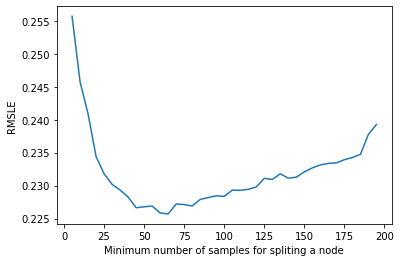

In [7]:
kf = KFold(n_splits=10)
cv_arr = []
for i in range(5, 200, 5):
    rmsle = []

    for train_index, test_index in kf.split(x):
        tree = DTG(min_samples_split = i).fit(x[train_index], y[train_index])
        y_predict = tree.predict(x[test_index])
        y_predict = np.asarray([max(x, 0) for x in y_predict])
        rmsle.append(compute_rmsle(y[test_index], y_predict))
    cv_arr.append(np.mean(rmsle))

plt.ylabel('RMSLE')
plt.xlabel('Minimum number of samples for spliting a node')
plt.plot(np.arange(5,200,5), cv_arr)
print(np.min(cv_arr))

In [8]:
print(np.argmin(cv_arr))

12


In [41]:
rmsle = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x):
    tree = AdaBoostRegressor(base_estimator=DTG(min_samples_split = 10), 
                             n_estimators=70,
                             loss='linear').fit(x[train_index], y[train_index])
    y_predict = tree.predict(x[test_index])
    y_predict = np.asarray([max(x, 0) for x in y_predict])
    rmsle.append(compute_rmsle(y[test_index], y_predict))
  
print(np.mean(np.asarray(rmsle)))

0.18092089571792175


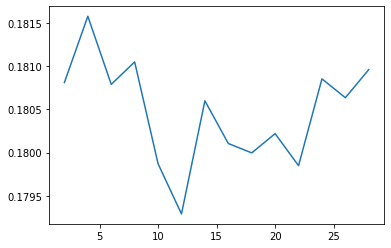

In [12]:
para_tuning=[]
for i in range(2, 30, 2):
    rmsle = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        tree = AdaBoostRegressor(base_estimator=DTG(min_samples_split = i), 
                                 n_estimators=70,
                                 loss='linear').fit(x[train_index], y[train_index])
        y_predict = tree.predict(x[test_index])
        y_predict = np.asarray([max(x, 0) for x in y_predict])
        rmsle.append(compute_rmsle(y[test_index], y_predict))

    para_tuning.append(np.mean(np.asarray(rmsle)))

plt.plot(np.arange(2, 30, 2), para_tuning)
plt.show()

In [44]:
para_tuning=[]
for i in range(50, 80, 5):
    rmsle = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        tree = AdaBoostRegressor(base_estimator=DTG(min_samples_split = 10), 
                                 n_estimators=i,
                                 loss='linear').fit(x[train_index], y[train_index])
        y_predict = tree.predict(x[test_index])
        y_predict = np.asarray([max(x, 0) for x in y_predict])
        rmsle.append(compute_rmsle(y[test_index], y_predict))

    para_tuning.append(np.mean(np.asarray(rmsle)))
print(para_tuning)

[0.18074650365663586, 0.1810283309879288, 0.1814295963704023, 0.18068530019226323, 0.17971074989322455, 0.18018064156799588]


In [38]:
rmsle = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x):
    tree = RandomForestRegressor(n_estimators=100,
                                 min_samples_split=20,
                                 ).fit(x[train_index], y[train_index])
    y_predict = tree.predict(x[test_index])
    y_predict = np.asarray([max(x, 0) for x in y_predict])
    rmsle.append(compute_rmsle(y[test_index], y_predict))
  
print(np.mean(np.asarray(rmsle)))

0.18508991806784084


In [39]:
rmsle = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x):
    tree = BaggingRegressor(base_estimator=DTG(min_samples_split = 20, min_samples_leaf = 10), 
                            n_estimators=10,
                            bootstrap=True).fit(x[train_index], y[train_index])
    y_predict = tree.predict(x[test_index])
    y_predict = np.asarray([max(x, 0) for x in y_predict])
    rmsle.append(compute_rmsle(y[test_index], y_predict))
  
print(np.mean(np.asarray(rmsle)))

0.19546433831280327


In [40]:
rmsle = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x):
    tree = BaggingRegressor(base_estimator=DTG(min_samples_split = 20, min_samples_leaf = 10), 
                            n_estimators=10,
                            bootstrap=True).fit(x[train_index], y[train_index])
    y_predict = tree.predict(x[test_index])
    y_predict = np.asarray([max(x, 0) for x in y_predict])
    rmsle.append(compute_rmsle(y[test_index], y_predict))
  
print(np.mean(np.asarray(rmsle)))

[0.19531288416980733, 0.19653735825306318, 0.18239284737398118, 0.1899905155815106, 0.20119786328899658, 0.19393490169616395, 0.19592170454547395, 0.21385815259720967, 0.19197805984172236, 0.19351909578010387]
